In [1]:
import os
import cv2
import numpy as np
from time import time
import pymatreader as pymat
from termcolor import colored
import matplotlib.pyplot as plt
from pysptools import material_count, eea, abundance_maps, distance, noise

### ${\color{black}{\bf{\text{Table of Contents:}}}}$
$\newline$
[${\bf{{\text{Data Preprocessing}}}}$](#0)
$\newline$
[${\bf{{\text{Old Method}}}}$](#-1)
$\newline$
* * [${\bf{\text{Data Loading}}}$](#1)
$\newline$
* * [${\bf{\text{Reshaping}}}$](#2)
$\newline$
* * [${\bf{\text{Function Definition}}}$](#3)
$\newline$
* * * [${\text{Data Normalization and Synthetic Data Generation}}$](#4)
$\newline$
* * [${\bf{\text{Data Asigning}}}$](#5)
$\newline$
* * [${\bf{\text{HySime Block}}}$](#6)
$\newline$
* * [${\bf{\text{NFINDR Block}}}$](#7)
$\newline$
* * [${\bf{\text{FCLS(Fully Constrained Least Squares) Block}}}$](#8)
$\newline$
* * * [${\text{Checking the Conditions}}$](#9)
$\newline$
* * [${\bf{\text{UCLS(Unconstrained Least Squares) block}}}$](#15)
$\newline$
* * [${\bf{\text{NNLS(Non-negative Constrained Least Squares) Block}}}$](#16)
$\newline$
* * * [${\text{Checking the Conditions}}$](#17)
$\newline$
* * [${\bf{\text{Taking and Plotting the Ubundance Map}}}$](#10)
$\newline$
[//]:#
$\newline$
[${\bf{{\text{SUNSAL Algorithm}}}}$](#11)
$\newline$
- [${\text{Checking the Conditions}}$](#12)
$\newline$
[//]:#
$\newline$
[${\bf{\text{Evaluation: SUNSAL and FCLSU}}}$](#19)
$\newline$
- [${\text{Checking the Conditions}}$](#20)
$\newline$
- [${\text{FCLSU Result}}$](#21)
$\newline$
- [${\text{SUNSAL Result}}$](#22)
$\newline$
[//]:#
$\newline$
[${\bf{\text{Spectral Angle Mapper(SAM)}}}$](#13)
$\newline$
[${\bf{\text{Denoising by Using MNF Transformation}}}$](#18)
$\newline$
[${\bf{\text{References}}}$](#14)

- [ ] **Task 1**

### <a name='-1'>[$${{\bf{\text{Old Method}}}}$$](https://pysptools.sourceforge.io/abundance_maps.html)</a>
$\newline$
$\newline$

<img src='Screenshot from 2022-12-12 14-24-57.png' style='width: 1500px; height: 600px'>

#### <a name='0'>${{\bf{\text{Data Preprocessing}}}}$</a> 

- <a name='1'>${\bf{{\text{Data Loading}}}}$</a> 

In [2]:
path_str = os.getcwd() + '/'

In [3]:
file_name_corr_str = 'Indian_pines_corrected.mat'
file_name_gt_str = 'Indian_pines_gt.mat'

In [4]:
data_gt_dict = pymat.read_mat(path_str + file_name_gt_str)
data_corr_dict = pymat.read_mat(path_str + file_name_corr_str)

data_gt_ndarray = data_gt_dict['indian_pines_gt']
data_corr_ndarray = data_corr_dict['indian_pines_corrected']

- <a name='2'>${\bf{{\text{Data Reshaping}}}}$</a> 

In [5]:
m, n, d = data_corr_ndarray.shape
data_corr_2d = np.reshape(data_corr_ndarray, newshape=(m*n, d))
data_gt_1d = data_gt_ndarray.flatten()
print(f'\nNew Dimensions of {colored("Data", "blue")}: {data_corr_2d.shape}')
print(f' ... and its {colored("Data type", "blue")}: {colored(data_corr_2d.dtype, "blue")}\n\n')
print(f'New Dimensions of {colored("Label", "blue")}: {data_gt_1d.shape}')
print(f' ... and its {colored("Data type", "blue")}: {colored(data_gt_1d.dtype, "blue")}\n')


New Dimensions of Data: (21025, 200)
 ... and its Data type: uint16


New Dimensions of Label: (21025,)
 ... and its Data type: uint8



- <a name='3'>${\bf{{\text{Function Definition}}}}$</a> 

In [6]:
def standard_normalization(data_2d: np.ndarray) -> np.ndarray:
    
    data = data_2d.copy()
    mean_value = data.mean()
    std_value = data.std()
    new_data = (data - mean_value) / (std_value)
    return new_data

In [7]:
def synthetic_noisy_data_generator(data_2d: np.ndarray, SNR_db: float=0, mode: str='gaussian') -> \
(np.ndarray, np.ndarray):
    
    data = data_2d.copy()
    m, n = data.shape
    
    mu, std = 0, 1
    if mode == 'gaussian':
        N = np.random.normal(mu, std, size=(m, n))
    elif mode == 'poisson':
        N = np.random.poisson(lam=1, size=(m, n))
    SNR = 10 ** (SNR_db / 10)
    
    E_x2 = (data ** 2).mean()
    A_coeff = (SNR / E_x2) ** (0.5)
#     noisy_data = (A_coeff * data) + N
    noisy_data = data + ((1/A_coeff) * N)
    return noisy_data, N

- <a name='4'>${\bf{{\text{Data Normalization and Synthetic Data Generation}}}}$</a> 

In [8]:
normal_data = standard_normalization(data_corr_2d)
synthetic_data, N = synthetic_noisy_data_generator(normal_data, SNR_db=0)

In [9]:
# Test:
expected_std_of_synthetic_data = (normal_data.std() + \
                                  N.std() + 2*(N*normal_data).mean())**(0.5)
print(f'\n{colored("Expected std", "blue")} for synthetic data: {colored(expected_std_of_synthetic_data, "blue")}\n')
print(f'{colored("Actual std", "blue")} of synthetic data: {colored(synthetic_data.std(), "blue")}\n')


Expected std for synthetic data: 1.4142277433488113

Actual std of synthetic data: 1.4142559184564607



- <a name='5'>${\bf{{\text{Data Asigning}}}}$</a> 

In [10]:
# Asigning the input data
input_data = synthetic_data
print(f'\nShape of {colored("Input Data", "blue")}: {input_data.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(input_data.dtype, "blue")}\n')


Shape of Input Data: (21025, 200)

 ... and its Data Type: float64



- <a name='6'>${\bf{{\text{HySime Block}}}}$</a>

In [11]:
# Rn: Corr
RN = np.identity(input_data.shape[1])
print(f'\n{colored("RN", "blue")} is Correlation Matrix of noise that in this example is \
{colored("Identity Matrix", "blue")} and shape of this is: {RN.shape}\n')
print(f' ... and its {colored("Data Type", "blue")} is: {colored(RN.dtype, "blue")}\n')


RN is Correlation Matrix of noise that in this example is Identity Matrix and shape of this is: (200, 200)

 ... and its Data Type is: float64



In [12]:
# q: No. Endmembers
q = (material_count.vd.hysime(y=input_data, n=N, Rn=RN))[0]
print(f'\nNo. Endmembers(q): {colored(q, "blue")}\n')


No. Endmembers(q): 3



- <a name='7'>${\bf{{\text{NFINDR Block}}}}$</a> 

In [13]:
# eea: Endmeber Extraction Algorithm
nfindr = eea.NFINDR()

In [14]:
# U: Endmeber Matrix
input_data_HSI_cube = data_corr_ndarray
U = nfindr.extract(M=input_data_HSI_cube, q=int(q))
U = U.astype(np.float64)
print(f'\nShape of the {colored("U", "blue")}(Endmembers): {U.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(U.dtype, "blue")}\n')


Shape of the U(Endmembers): (3, 200)

 ... and its Data Type: float64



- <a name='8'>${\bf{{\text{FCLS(Fully Constrained Least Squares) Block}}}}$</a> 

In [15]:
tic = time()
X = abundance_maps.amaps.FCLS(M=input_data, U=U)
toc = time()
run_time = toc - tic
X = X.astype(np.float64)

print(f'\nShape of the {colored("Abundance Matrix(X)", "blue")} for {colored("FCLS", "blue")} Method: {X.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for this method: {colored(run_time, "red")}(s)\n')


Shape of the Abundance Matrix(X) for FCLS Method: (21025, 3)

 ... and its Data Type: float64


Run time for this method: 18.769447088241577(s)



- - <a name='9'>${\bf{{\text{Checking the Conditions}}}}$</a>

In [16]:
# Exploring the Non-Negativity Constraint(NNC)
b = X[X < 0]
print(b)

[]


In [17]:
# Exploring the Sum-to-one Constraint
np.sum(X[10])

1.0000000062651164

- <a name='15'>${\bf{{\text{UCLS(Unconstrained Least Squares) Block}}}}$</a> 

In [18]:
tic = time()
X_UCLS = abundance_maps.amaps.UCLS(M=input_data, U=U)
toc = time()
run_time = toc - tic
X_UCLS = X_UCLS.astype(np.float64)

print(f'\nShape of the {colored("Abundance Matrix(X)", "blue")} for {colored("UCLS", "blue")} Method: {X.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_UCLS.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for this method: {colored(run_time, "red")}(s)\n')


Shape of the Abundance Matrix(X) for UCLS Method: (21025, 3)

 ... and its Data Type: float64


Run time for this method: 0.006573677062988281(s)



- <a name='16'>${\bf{{\text{NNLS(non-negative constrained Least Squares) Block}}}}$</a> 

In [19]:
tic = time()
X_NNLS = abundance_maps.amaps.NNLS(M=input_data, U=U)
toc = time()
run_time = toc - tic
X_NNLS = X_NNLS.astype(np.float64)

print(f'\nShape of the {colored("Abundance Matrix(X)", "blue")} for {colored("NNLS", "blue")} Method: {X.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_NNLS.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for this method: {colored(run_time, "red")}(s)\n')


Shape of the Abundance Matrix(X) for NNLS Method: (21025, 3)

 ... and its Data Type: float64


Run time for this method: 0.2659611701965332(s)



* * <a name='17'>${\bf{\text{Checking the Conditions}}}$</a>

In [20]:
b2 = X_NNLS[X_NNLS < 0]
print(b2)

[]


- <a name='10'>${\bf{{\text{Taking and Plotting the Abundance Map}}}}$</a> 

In [21]:
abundance_map = abundance_maps.FCLS()

In [22]:
U2 = abundance_map.map(M=input_data_HSI_cube, U=U)

In [23]:
abundance_map.plot(path=path_str)

<Figure size 640x480 with 0 Axes>

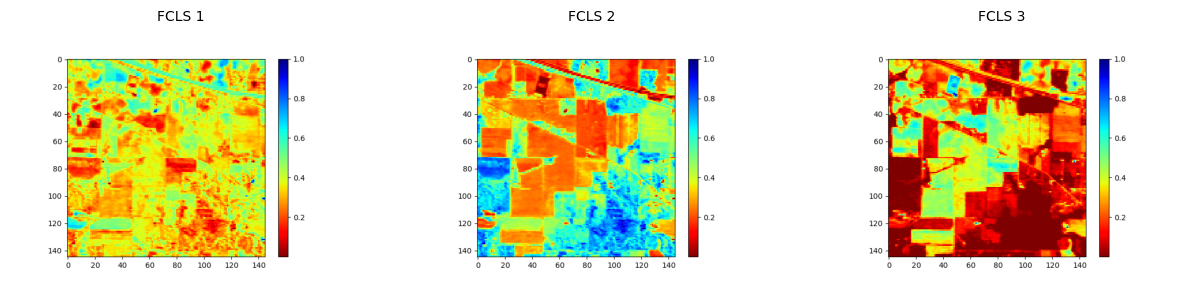

In [24]:
img1, img2, img3 = cv2.imread(path_str + 'FCLS_1.png'), cv2.imread(path_str + 'FCLS_2.png'), \
cv2.imread(path_str + 'FCLS_3.png')

plt.figure(num=1, figsize=(15, 15))
plt.subplot(1, 3, 1), plt.imshow(img1), plt.axis('off'), plt.title('FCLS 1', fontsize=10)
plt.subplot(1, 3, 2), plt.imshow(img2), plt.axis('off'), plt.title('FCLS 2', fontsize=10)
plt.subplot(1, 3, 3), plt.imshow(img3), plt.axis('off'), plt.title('FCLS 3', fontsize=10)
plt.show()

- [x] **Task 1**

- [ ] **Task 2**

### <a name='11'>[$${{\bf{\text{SUNSAL Algorithm}}}}$$](https://github.com/Laadr/SUNSAL)</a>
$\newline$
$\newline$
$\newline$
$\newline$

In [25]:
import sunsal

In [26]:
U3, y3 = U.reshape((U.shape[1], U.shape[0])), input_data.reshape((input_data.shape[1], input_data.shape[0]))

In [27]:
tic = time()
X_sunsal, _, _, _ = sunsal.sunsal(M=U3, y=y3, positivity=True, addone=True)
toc = time()
sunsal_run_time = toc - tic
X_sunsal = X_sunsal.reshape((X_sunsal.shape[1], X_sunsal.shape[0]))
print(f'\nShape of {colored("Abundance Matrix", "blue")}: {colored(X_sunsal.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_sunsal.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for {colored("SUNSAL", "blue")} Method: {colored(sunsal_run_time, "red")}(s)\n')


Shape of Abundance Matrix: (21025, 3)

 ... and its Data Type: float64


Run time for SUNSAL Method: 0.03113865852355957(s)



In [28]:
print(f'\nShape of the Unmixing by using {colored("SUNSAL Algorithm", "blue")}: {X_sunsal.shape}\n')


Shape of the Unmixing by using SUNSAL Algorithm: (21025, 3)



- <a name='12'>${\bf{{\text{Checking the Conditions}}}}$</a> 

In [29]:
# Exploring the Sum-to-one Constraint
np.sum(X_sunsal[10])

0.9764317031646899

In [30]:
# Exploring the Non-Negativity Constraint(NNC)
b2 = X_sunsal[X_sunsal < 0]
print(b2)

[]


- [x] **Task 2**

$\newline$
<a name='19'>${\bf{\text{Evaluation: SUNSAL and FCLSU}}}$</a>
$\newline$

In [32]:
def E_norm2(X: np.ndarray) -> float:
    No_pixels = len(X)
    norms_2 = np.zeros((No_pixels, ))
    for i, vect in enumerate(X):
        norms_2[i] = (np.linalg.norm(vect, ord=2)) ** 2
    
    result = np.sum(norms_2) / len(norms_2)
    return result

In [67]:
file_name_str = '/Synthetic_Data/SNR_10/'
abundance_str = 'Abundance.mat'
data_str = 'Generated_data.mat'
endmembers_str = 'Endmembers.mat'
noise_str = 'Noise.mat'
noise_correlation_str = 'Noise_Correlation.mat'

In [68]:
y_test = pymat.read_mat(path_str + file_name_str + data_str)['y']
y_test = y_test.astype(np.float64)
y_test = y_test.reshape((y_test.shape[1], y_test.shape[0]))


U_test = pymat.read_mat(path_str + file_name_str + endmembers_str)['M']
U_test = U_test.astype(np.float64)
U_test = U_test.reshape((U_test.shape[1], U_test.shape[0]))

X_test = pymat.read_mat(path_str + file_name_str + abundance_str)['s']
X_test = X_test.astype(np.float64)

N_test = pymat.read_mat(path_str + file_name_str + noise_str)['n']
N_test = N_test.astype(np.float64)
N_test = N_test.reshape(N_test.shape[1], N_test.shape[0])

N_Corr_test = pymat.read_mat(path_str + file_name_str + noise_correlation_str)['Cn']
N_Corr_test = N_Corr_test.astype(np.float64)


noisy_y_test = y_test + N_test

In [69]:
print(f'\nShape of {colored("y_test", "blue")}(Data): {colored(y_test.shape, "blue")} = \
(No. pixels, No. features)')
print(f'\nShape of {colored("U_test", "blue")}(Endmembers): {colored(U_test.shape, "blue")} = \
(q, No. features)')
print(f'\nShape of {colored("X_test", "blue")}(Abundance): {colored(X_test.shape, "blue")} = \
(No. pixels, q)')
print(f'\nShape of {colored("N_test", "blue")}(Noise): {colored(N_test.shape, "blue")}')
print(f'\nShape of {colored("N_Corr_test", "blue")}(Correlation of the Noise): \
{colored(N_Corr_test.shape, "blue")}\n')


Shape of y_test(Data): (220, 224) = (No. pixels, No. features)

Shape of U_test(Endmembers): (4, 224) = (q, No. features)

Shape of X_test(Abundance): (220, 4) = (No. pixels, q)

Shape of N_test(Noise): (220, 224)

Shape of N_Corr_test(Correlation of the Noise): (224, 224)



- <a name='20'>${\bf{\text{Checking the Conditions}}}$</a>

In [70]:
list(X_test[X_test < 0])

[]

In [71]:
np.sum(X_test[0, :])

1.0000000000000002

- <a name='21'>${\bf{\text{FCLSU Result}}}$</a>

In [72]:
tic = time()
X_hat_FCLSU = abundance_maps.amaps.FCLS(M=noisy_y_test, U=U_test)
toc = time()
run_time = toc - tic
X_hat_FCLSU = X_hat_FCLSU.astype(np.float64)

print(f'\nShape of the Abundance Matrix(X\u0302) for {colored("FCLS", "blue")} Method: \
{colored(X_hat_FCLSU.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_hat_FCLSU.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for this method: {colored(run_time, "red")}(s)\n')


Shape of the Abundance Matrix(X̂) for FCLS Method: (220, 4)

 ... and its Data Type: float64


Run time for this method: 0.135528564453125(s)



- <a name='22'>${\bf{\text{SUNSAL Result}}}$</a>

In [73]:
U3, y3 = U_test.reshape((U_test.shape[1], U_test.shape[0])), \
noisy_y_test.reshape((noisy_y_test.shape[1], noisy_y_test.shape[0]))

In [74]:
tic = time()
X_hat_sunsal, _, _, _ = sunsal.sunsal(M=U3, y=y3, positivity=True, addone=True)
toc = time()
sunsal_run_time = toc - tic
X_hat_sunsal = X_hat_sunsal.reshape((X_hat_sunsal.shape[1], X_hat_sunsal.shape[0]))
print(f'\nShape of {colored("Abundance Matrix", "blue")}: {colored(X_hat_sunsal.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_hat_sunsal.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for {colored("SUNSAL", "blue")} Method: {colored(sunsal_run_time, "red")}(s)\n')


Shape of Abundance Matrix: (220, 4)

 ... and its Data Type: float64


Run time for SUNSAL Method: 0.005330562591552734(s)



$\newline$
- <a name='23'>${\bf{\text{RSNR Calculation}}}$</a>
$\newline$

In [75]:
Numerator = E_norm2(X_test)
Denumerator_FCLSU = E_norm2(X_test - X_hat_FCLSU)
Denumerator_SUNSAL = E_norm2(X_test - X_hat_sunsal)

RSNR_FCLSU = Numerator / Denumerator_FCLSU
RSNR_FCLSU_db = 10 * np.log10(RSNR_FCLSU)

RSNR_SUNSAL = Numerator / Denumerator_SUNSAL
RSNR_SUNSAL_db = 10 * np.log10(RSNR_SUNSAL)

print(f'\n{colored("RSNR(db)", "blue")} for {colored("FCLSU", "blue")}: {colored(RSNR_FCLSU_db, "blue")}\n')
print(f'\n{colored("RSNR(db)", "blue")}: for {colored("SUNSAL", "blue")}: {colored(RSNR_SUNSAL_db, "blue")}\n')


RSNR(db) for FCLSU: 0.35258391932735156


RSNR(db): for SUNSAL: 0.7223033892703126



- [ ] **Task 3**

### <a name='13'>[$${{\bf{\text{Spectral Angle Mapper(SAM)}}}}$$](https://pysptools.sourceforge.io/distance.html)</a>

In [44]:
sam_before_MNF = distance.SAM(input_data_HSI_cube[0, 0, :], input_data_HSI_cube[0, 1, :])
print(f'\n{colored("SAM Distance", "blue")} {colored("before", "green")} MNF \
Transformation: {colored(sam_before_MNF, "blue")}\n')


SAM Distance before MNF Transformation: 1.3957062484243536



- [x] **Task 3**

- [ ] **Task 4**

### <a name='18'>$${\bf{{\text{Denoising by using MNF Transformation}}}}$$</a>

In [45]:
MNF = noise.MNF()

In [46]:
MNF_result = MNF.apply(M=input_data_HSI_cube)
print(f'\nShape of the Result of the {colored("MNF Transformation", "blue")}: {MNF_result.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(MNF_result.dtype, "blue")}\n')


Shape of the Result of the MNF Transformation: (145, 145, 200)

 ... and its Data Type: float64



In [47]:
sam_after_MNF = distance.SAM(MNF_result[0, 0, :], MNF_result[0, 1, :])
print(f'\n{colored("SAM Distance", "blue")} {colored("after", "green")} MNF \
Transformation: {colored(sam_after_MNF, "blue")}\n')


SAM Distance after MNF Transformation: 0.3442784534022258



- [x] **Task 4**

### <a name='14'>${\bf{\text{References:}}}$</a>
$\newline$
- [${\bf{\text{Old Method}}}$](https://pysptools.sourceforge.io/abundance_maps.html)
$\newline$
- [${\bf{\text{SUNSAL Algorithm}}}$](https://github.com/Laadr/SUNSAL)
$\newline$
- [${\bf{\text{Spectral Angle Mapper(SAM)}}}$](https://pysptools.sourceforge.io/distance.html)
$\newline$
- [${\bf{\text{Minimum Noise Fraction(MNF) Transformation}}}$](https://pysptools.sourceforge.io/noise.html)
$\newline$
- [${\bf{\text{NFINDR}}}$](https://pysptools.sourceforge.io/eea.html)
$\newline$
- [${\bf{\text{HySime}}}$](https://pysptools.sourceforge.io/material_count.html)
$\newline$
- [${\bf{\text{Denoising by using Minimum Noise Fraction(MNF) Transformation}}}$](https://pysptools.sourceforge.io/noise.html)
$\newline$